In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"swetanshuprasad","key":"cce3f35ae4075f31b93bb182de80ca24"}'}

In [3]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle dataset list


usage: kaggle [-h] [-v] [-W] {competitions,c,datasets,d,kernels,k,models,m,files,f,config} ...
kaggle: error: argument command: invalid choice: 'dataset' (choose from 'competitions', 'c', 'datasets', 'd', 'kernels', 'k', 'models', 'm', 'files', 'f', 'config')


In [7]:
!kaggle competitions download -c shl-intern-hiring-assessment

User cancelled operation


In [20]:
!unzip  /content/shl-intern-hiring-assessment.zip

Archive:  /content/shl-intern-hiring-assessment.zip
replace dataset/audios_test/audio_10.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [8]:
import pandas as pd
import os

# Optional: You might also want to import libraries for numerical operations
import numpy as np

In [9]:
train_df = pd.read_csv('/content/dataset/train.csv')
test_df = pd.read_csv('/content/dataset/test.csv')

In [10]:
train_df.head()

,filename,label
0,audio_1261.wav,1.0
1,audio_942.wav,1.5
2,audio_1110.wav,1.5
3,audio_1024.wav,1.5
4,audio_538.wav,2.0


In [11]:
test_df.head()

,filename
0,audio_706.wav
1,audio_800.wav
2,audio_68.wav
3,audio_1267.wav
4,audio_683.wav


In [12]:
import pandas as pd
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

# For reproducibility
np.random.seed(42)

## 1. Data Loading and Initial Exploration   


# Load the training, testing, and sample submission CSV files into pandas DataFrames.
# Pandas DataFrames provide a structured way to work with tabular data.::

In [13]:
# Assuming your CSV files are in the same directory as your notebook
train_df = pd.read_csv('/content/dataset/train.csv')
test_df = pd.read_csv('/content/dataset/test.csv')
sample_submission = pd.read_csv('/content/dataset/sample_submission.csv')

print("Training Data:")
print(train_df.head(10))
print("\nTesting Data:")
print(test_df.head())
print("\nSample Submission:")
print(sample_submission.head())

Training Data:
         filename  label
0  audio_1261.wav    1.0
1   audio_942.wav    1.5
2  audio_1110.wav    1.5
3  audio_1024.wav    1.5
4   audio_538.wav    2.0
5   audio_350.wav    2.5
6    audio_64.wav    2.0
7   audio_252.wav    2.0
8  audio_1304.wav    2.0
9  audio_1230.wav    2.5

Testing Data:
         filename
0   audio_706.wav
1   audio_800.wav
2    audio_68.wav
3  audio_1267.wav
4   audio_683.wav

Sample Submission:
         filename  label
0   audio_706.wav      0
1   audio_800.wav      0
2    audio_68.wav      0
3  audio_1267.wav      0
4   audio_683.wav      0


In [14]:
audio_dir_train = '/content/dataset/audios_train'
audio_dir_test = '/content/dataset/audios_test'

# Setting Up Audio File Paths

This section focuses on creating the full paths to the audio files for both the training and testing datasets. These paths are essential for loading and processing the audio data in subsequent steps.

First, we define variables `audio_dir_train` and `audio_dir_test` to store the names of the directories where the training and testing audio files are located, respectively. It is assumed that these directories are in the same location as the notebook.

Next, we create a new column named `audio_path` in both the `train_df` and `test_df` DataFrames. This is done using the `.apply()` method on the `filename` column of each DataFrame. For each filename, a lambda function is used in conjunction with `os.path.join()` to construct the complete path by combining the respective audio directory with the filename. `os.path.join()` ensures that the path is created correctly regardless of the operating system.

To verify that the paths have been constructed as expected, we print the first few rows of the `train_df` and `test_df`, displaying the original `filename` alongside the newly created `audio_path`. This allows for a quick visual inspection.

Finally, as an optional debugging step, we iterate through the first few generated audio paths for both the training and testing sets and use `os.path.exists()` to check if the files actually exist at those locations on the file system. The result of this check (True or False) is printed for each path, which can be helpful in identifying any issues with file organization or path construction.

In [15]:
train_df['audio_path'] = train_df['filename'].apply(lambda x: os.path.join(audio_dir_train, x))

# Construct the full paths for testing audio files
test_df['audio_path'] = test_df['filename'].apply(lambda x: os.path.join(audio_dir_test, x))

# Verify a few paths for training data
print("\nExample Training Audio Paths:")
print(train_df[['filename', 'audio_path']].head())

# Verify a few paths for testing data
print("\nExample Testing Audio Paths:")
print(test_df[['filename', 'audio_path']].head())

# Check if the first few training audio files exist (optional, but good for debugging)
print("\nChecking if the first few training audio files exist:")
for path in train_df['audio_path'].head():
    print(f"{path}: {os.path.exists(path)}")

# Check if the first few testing audio files exist (optional)
print("\nChecking if the first few testing audio files exist:")
for path in test_df['audio_path'].head():
    print(f"{path}: {os.path.exists(path)}")


Example Training Audio Paths:
         filename                                    audio_path
0  audio_1261.wav  /content/dataset/audios_train/audio_1261.wav
1   audio_942.wav   /content/dataset/audios_train/audio_942.wav
2  audio_1110.wav  /content/dataset/audios_train/audio_1110.wav
3  audio_1024.wav  /content/dataset/audios_train/audio_1024.wav
4   audio_538.wav   /content/dataset/audios_train/audio_538.wav

Example Testing Audio Paths:
         filename                                   audio_path
0   audio_706.wav   /content/dataset/audios_test/audio_706.wav
1   audio_800.wav   /content/dataset/audios_test/audio_800.wav
2    audio_68.wav    /content/dataset/audios_test/audio_68.wav
3  audio_1267.wav  /content/dataset/audios_test/audio_1267.wav
4   audio_683.wav   /content/dataset/audios_test/audio_683.wav

Checking if the first few training audio files exist:
/content/dataset/audios_train/audio_1261.wav: True
/content/dataset/audios_train/audio_942.wav: True
/content/dataset/audi

# Step 4: Basic Data Exploration

This section performs initial exploration of the training dataset to understand its structure and the distribution of the target variable.

First, `print("\nTraining Data Info:")` prints a header to clearly indicate the output that follows. Then, `print(train_df.info())` displays a concise summary of the `train_df` DataFrame. This includes information about the number of rows and columns, the data type of each column, and the number of non-null values in each column. This is useful for quickly assessing the overall structure of the training data and identifying any potential missing values or incorrect data types.

Next, `print("\nTraining Grammar Score Distribution:")` prints another header. `print(train_df['label'].value_counts().sort_index())` calculates and displays the distribution of the grammar score labels in the `train_df`. `.value_counts()` returns a Series containing the counts of unique values in the 'label' column, and `.sort_index()` sorts these counts based on the grammar score values themselves, providing a clear view of how many samples fall into each score category.

Finally, `print("\nTraining Grammar Score Statistics:")` prints a header, and `print(train_df['label'].describe())` provides descriptive statistics for the 'label' column. This includes measures such as the mean, standard deviation, minimum, maximum, and quartiles of the grammar scores, offering a statistical overview of the target variable's range and central tendency in the training data.

In [16]:
# Step 4: Basic Data Exploration

print("\nTraining Data Info:")
print(train_df.info())

print("\nTraining Grammar Score Distribution:")
print(train_df['label'].value_counts().sort_index())

print("\nTraining Grammar Score Statistics:")
print(train_df['label'].describe())


Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   filename    444 non-null    object 
 1   label       444 non-null    float64
 2   audio_path  444 non-null    object 
dtypes: float64(1), object(2)
memory usage: 10.5+ KB
None

Training Grammar Score Distribution:
label
1.0      1
1.5      3
2.0     70
2.5     40
3.0     87
3.5     23
4.0     52
4.5     58
5.0    110
Name: count, dtype: int64

Training Grammar Score Statistics:
count    444.000000
mean       3.617117
std        1.114151
min        1.000000
25%        2.500000
50%        3.500000
75%        4.500000
max        5.000000
Name: label, dtype: float64


# Visualizing Sample Audio Data

This section demonstrates how to load and visualize a representative audio file from the training dataset using the `librosa` library for audio processing and `matplotlib` for plotting.

First, `sample_audio_path = train_df['audio_path'].iloc[0]` selects the file path of the very first audio sample from the `audio_path` column of the training DataFrame. Similarly, `sample_grammar_score = train_df['label'].iloc[0]` retrieves the corresponding grammar score (label) for this first audio sample from the `label` column.

Next, `print(f"\nLoading sample audio: {sample_audio_path}")` and `print(f"Corresponding grammar score: {sample_grammar_score}")` display the path of the audio file being loaded and its associated grammar score for informational purposes.

A `try-except` block is used to handle potential errors during audio loading and processing. Inside the `try` block:
- `y, sr = librosa.load(sample_audio_path)` loads the audio file specified by `sample_audio_path` using `librosa.load()`. This function returns the audio time series (`y`) and the sampling rate (`sr`).
- `print(f"Sample rate (sr): {sr}")` and `print(f"Audio duration: {librosa.get_duration(y=y, sr=sr)} seconds")` print the sampling rate and the calculated duration of the loaded audio.
- The subsequent code then generates two visualizations:
    - **Waveform:** `plt.figure(figsize=(12, 4))` creates a figure for the plot. `librosa.display.waveshow(y, sr=sr)` plots the amplitude of the audio signal over time. `plt.title(...)`, `plt.xlabel(...)`, `plt.ylabel(...)`, and `plt.show()` set the title, axis labels, and display the waveform plot.
    - **Spectrogram:** `D = librosa.stft(y)` computes the Short-Time Fourier Transform (STFT) of the audio signal. `S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)` converts the magnitude of the STFT to decibels. `librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')` displays the spectrogram with time on the x-axis and frequency (on a logarithmic scale) on the y-axis. `plt.colorbar(...)`, `plt.title(...)`, and `plt.show()` add a color bar indicating the decibel levels, set the title, and display the spectrogram plot. `plt.tight_layout()` adjusts plot parameters for a tight layout.

The `except FileNotFoundError:` block catches the error if the audio file specified by `sample_audio_path` cannot be found. The `except Exception as e:` block catches any other potential errors that might occur during the audio loading or processing. In both error cases, an informative error message is printed.

This visualization step helps to gain a qualitative understanding of the audio data and its characteristics.


Loading sample audio: /content/dataset/audios_train/audio_1261.wav
Corresponding grammar score: 1.0
Sample rate (sr): 22050
Audio duration: 60.07469387755102 seconds


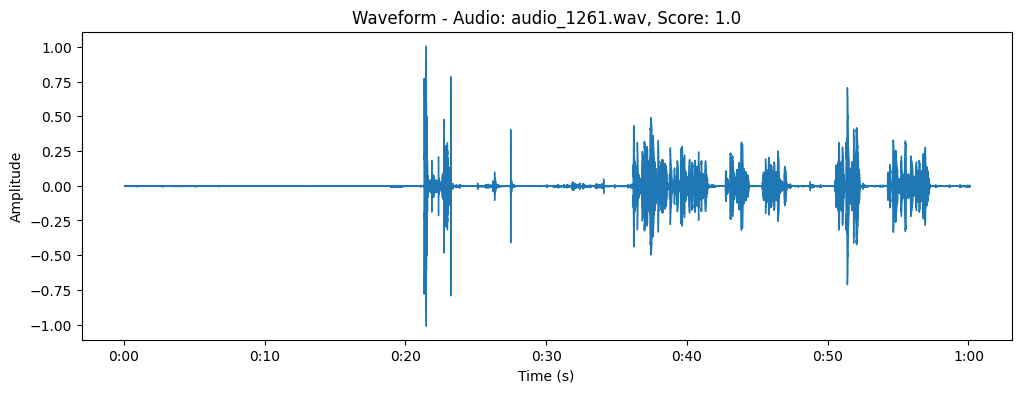

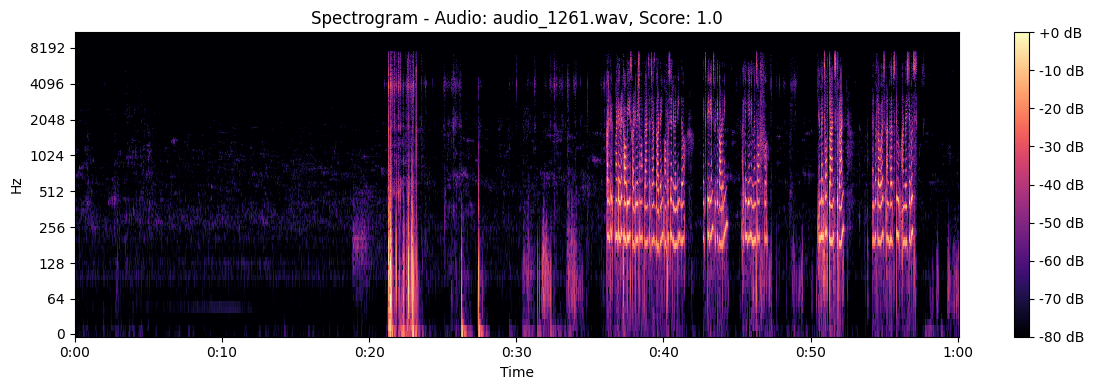

In [17]:
sample_audio_path = train_df['audio_path'].iloc[0]
sample_grammar_score = train_df['label'].iloc[0]  # Corrected to use 'label'

print(f"\nLoading sample audio: {sample_audio_path}")
print(f"Corresponding grammar score: {sample_grammar_score}")

try:
    y, sr = librosa.load(sample_audio_path)
    print(f"Sample rate (sr): {sr}")
    print(f"Audio duration: {librosa.get_duration(y=y, sr=sr)} seconds")

    # Visualize the waveform
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform - Audio: {train_df["filename"].iloc[0]}, Score: {sample_grammar_score}')  # Corrected to use 'filename'
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

    # Visualize the spectrogram
    D = librosa.stft(y)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram - Audio: {train_df["filename"].iloc[0]}, Score: {sample_grammar_score}')  # Corrected to use 'filename'
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"Error: Audio file not found at {sample_audio_path}")
except Exception as e:
    print(f"Error loading audio file: {e}")

# Defining and Applying MFCC Feature Extraction

This section defines a function to extract Mel-Frequency Cepstral Coefficients (MFCCs) from audio files and then applies this function to the training dataset. MFCCs are a widely used set of features in speech processing that represent the spectral envelope of a sound.

The code first defines a function called `extract_mfccs`. This function takes the `audio_path` of an audio file and the number of MFCC coefficients to extract (`n_mfcc`, defaulting to 20) as input. Inside the function, a `try-except` block is used to handle potential errors during audio loading and feature extraction.

Within the `try` block:
- `y, sr = librosa.load(audio_path, sr=None)` loads the audio file using the `librosa` library. The `sr=None` argument ensures that the audio is loaded with its original sampling rate.
- `mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)` calculates the MFCCs of the loaded audio signal.
- `return mfccs.T` returns the transposed MFCC array. The transposition is done so that each row of the resulting array represents a time frame, and each column represents a different MFCC coefficient. This format is often preferred for subsequent processing.

If any exception occurs during the audio loading or MFCC calculation, the `except` block catches it, prints an error message indicating the problematic audio file, and returns `None`.

After defining the `extract_mfccs` function, it is applied to the `audio_path` column of the `train_df` DataFrame using the `.apply()` method. The extracted MFCC array for each audio file is stored in a new column named `mfccs`.

Following the feature extraction, `train_df.dropna(subset=['mfccs'])` removes any rows from the `train_df` where the MFCC extraction failed (i.e., where the `mfccs` column contains `None`).

Finally, a message is printed indicating the number of training samples remaining after the MFCC extraction process. If the `train_df` is not empty, the shape of the extracted MFCC array for the first remaining sample is also printed as an example, providing insight into the dimensionality of the extracted features (number of time frames x number of MFCC coefficients).

In [18]:
# Define a function to extract MFCCs from an audio file
def extract_mfccs(audio_path, n_mfcc=20):
    """Extracts MFCC features from an audio file.

    Args:
        audio_path (str): Path to the audio file.
        n_mfcc (int): Number of MFCC coefficients to extract.

    Returns:
        numpy.ndarray: Array of MFCC coefficients, or None if loading fails.
    """
    try:
        y, sr = librosa.load(audio_path, sr=None)  # Load with original sample rate
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        return mfccs.T  # Transpose to have time frames as rows
    except Exception as e:
        print(f"Error extracting MFCCs from {audio_path}: {e}")
        return None

# Apply the feature extraction function to the training data
train_df['mfccs'] = train_df['audio_path'].apply(extract_mfccs)

# Remove rows where MFCC extraction failed
train_df = train_df.dropna(subset=['mfccs'])
print(f"\nNumber of training samples after MFCC extraction: {len(train_df)}")

# Example of the shape of the extracted MFCCs for the first sample
if not train_df.empty:
    print(f"\nShape of MFCCs for the first training sample: {train_df['mfccs'].iloc[0].shape}")


Number of training samples after MFCC extraction: 444

Shape of MFCCs for the first training sample: (1878, 20)


# Applying MFCC Feature Extraction to Training and Testing Data

This section applies the `extract_mfccs` function (defined previously) to both the training (`train_df`) and testing (`test_df`) datasets to generate MFCC features for each audio file.

For the training data, `train_df['mfccs'] = train_df['audio_path'].apply(extract_mfccs)` iterates through the `audio_path` column of the `train_df` and applies the `extract_mfccs` function to each audio file path. The resulting MFCC arrays are stored in a new column named `mfccs` within the `train_df`. Subsequently, `train_df = train_df.dropna(subset=['mfccs'])` removes any rows from the `train_df` where the MFCC extraction failed (indicated by `None` values in the `mfccs` column). A message is then printed to report the number of training samples remaining after successful MFCC extraction.

The same process is then repeated for the testing data. `test_df['mfccs'] = test_df['audio_path'].apply(extract_mfccs)` extracts MFCC features for each audio file in the `test_df` and stores them in the `mfccs` column. `test_df = test_df.dropna(subset=['mfccs'])` removes any rows from the `test_df` where MFCC extraction failed. Finally, a message is printed indicating the number of testing samples remaining after MFCC extraction.

This step ensures that both the training and testing datasets now contain a column of MFCC features for each successfully processed audio file, which will be used for further analysis and model training.

In [19]:
def extract_mfccs(audio_path, n_mfcc=20):
    try:
        y, sr = librosa.load(audio_path, sr=None)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        return mfccs.T
    except Exception as e:
        print(f"Error extracting MFCCs from {audio_path}: {e}")
        return None

train_df['mfccs'] = train_df['audio_path'].apply(extract_mfccs)
train_df = train_df.dropna(subset=['mfccs'])
print(f"\nNumber of training samples after MFCC extraction: {len(train_df)}")

test_df['mfccs'] = test_df['audio_path'].apply(extract_mfccs)
test_df = test_df.dropna(subset=['mfccs'])
print(f"Number of testing samples after MFCC extraction: {len(test_df)}")


Number of training samples after MFCC extraction: 444
Number of testing samples after MFCC extraction: 195


# Defining and Applying MFCC Feature Aggregation

This section defines a function to aggregate the extracted MFCC features and applies it to both the training and testing datasets. Since the MFCC features for each audio file are sequences of varying lengths (number of time frames), this aggregation step aims to create a fixed-size feature vector for each audio sample, which is suitable for many machine learning models.

The code first defines a function called `aggregate_mfccs` that takes an MFCC array as input. It checks if the input MFCC array is not `None` and has a size greater than zero. If these conditions are met, the function calculates the mean (`mfccs_mean`) and standard deviation (`mfccs_std`) of each MFCC coefficient across all the time frames (axis=0). These mean and standard deviation values capture important statistical characteristics of the MFCCs over the duration of the audio. The function then concatenates the mean and standard deviation arrays using `np.concatenate()` to create a single, fixed-length feature vector. If the input MFCC array is `None` or empty, the function returns `None`.

Next, this `aggregate_mfccs` function is applied to the `mfccs` column of the `train_df` DataFrame using the `.apply()` method. The resulting aggregated feature vectors are stored in a new column named `aggregated_mfccs`. Rows where the aggregation resulted in `None` are then removed from `train_df` using `train_df.dropna(subset=['aggregated_mfccs'])`.

The same aggregation process is then applied to the `mfccs` column of the `test_df` DataFrame, and the results are stored in the `aggregated_mfccs` column of `test_df`. Similarly, rows with `None` values in the `aggregated_mfccs` column of `test_df` are dropped.

After this step, both the training and testing DataFrames contain a new column (`aggregated_mfccs`) where each entry is a fixed-size numerical vector representing the aggregated statistical features of the MFCCs for the corresponding audio file. These aggregated features will be used as input for the machine learning model.

In [20]:
def aggregate_mfccs(mfccs):
    if mfccs is not None and mfccs.size > 0:
        mfccs_mean = np.mean(mfccs, axis=0)
        mfccs_std = np.std(mfccs, axis=0)
        return np.concatenate((mfccs_mean, mfccs_std))
    else:
        return None

train_df['aggregated_mfccs'] = train_df['mfccs'].apply(aggregate_mfccs)
train_df = train_df.dropna(subset=['aggregated_mfccs'])

test_df['aggregated_mfccs'] = test_df['mfccs'].apply(aggregate_mfccs)
test_df = test_df.dropna(subset=['aggregated_mfccs'])


# Preparing Data for Model Training

This section prepares the feature and target variables for training our machine learning model.

First, `X_train = np.array(list(train_df['aggregated_mfccs']))` extracts the aggregated MFCC feature vectors from the `aggregated_mfccs` column of the `train_df`. The `.apply()` method in the previous step resulted in a pandas Series where each element is a NumPy array (the aggregated feature vector). To prepare this for scikit-learn, we first convert this Series to a Python list and then convert this list into a single NumPy array named `X_train`. This `X_train` array will serve as the input features for our training model. Each row in `X_train` corresponds to an audio sample, and each column represents a feature (mean or standard deviation of an MFCC coefficient).

Next, `y_train = train_df['label'].values` extracts the grammar score labels from the `label` column of the `train_df`. The `.values` attribute converts the pandas Series of labels into a NumPy array named `y_train`. This array will be the target variable that our model will learn to predict. The order of elements in `y_train` corresponds to the order of the feature vectors in `X_train`.

Finally, `X_test = np.array(list(test_df['aggregated_mfccs']))` performs the same operation as the creation of `X_train`, but for the testing dataset. It extracts the aggregated MFCC feature vectors from the `aggregated_mfccs` column of the `test_df` and converts them into a NumPy array named `X_test`. This array will be used to make predictions with our trained model on unseen data.

After this step, we have our training features (`X_train`), training labels (`y_train`), and testing features (`X_test`) ready in a format that can be directly used by scikit-learn models.

In [21]:
X_train = np.array(list(train_df['aggregated_mfccs']))
y_train = train_df['label'].values
X_test = np.array(list(test_df['aggregated_mfccs']))

# ⚙️ Feature Scaling ⚙️

This step uses `StandardScaler` from scikit-learn to **standardize** our features. 📏

- `scaler = StandardScaler()`: Initializes the scaler.
- `X_train_scaled = scaler.fit_transform(X_train)`: **Fits** the scaler to the training data (`X_train`) to learn the mean and standard deviation of each feature, and then **transforms** the training data using these learned parameters. 🧠➡️🔢
- `X_test_scaled = scaler.transform(X_test)`: **Transforms** the testing data (`X_test`) using the **same** mean and standard deviation learned from the training data. This ensures consistency and prevents data leakage. 🧪➡️🔢

The result is that both training and testing features now have a mean of approximately zero and a standard deviation of approximately one, which can help improve the performance of many machine learning algorithms. ✨

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Selecting the Best Model Fit For the pridiction

In [31]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [43]:
# Replace LogisticRegression with LinearRegression
from sklearn.linear_model import LinearRegression  # Import if not already imported
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [44]:
predictions = model.predict(X_test_scaled)

In [45]:
predictions = np.clip(predictions, 0, 5)

In [46]:
X_train_pred = model.predict(X_train_scaled)
mse_train = mean_squared_error(y_train, X_train_pred)
r2_train = r2_score(y_train, X_train_pred)
pearson_corr_train, _ = pearsonr(y_train, X_train_pred)

print("\n--- Training Data Evaluation ---")
print(f"Mean Squared Error (MSE): {mse_train:.4f}")
print(f"R-squared (R2): {r2_train:.4f}")
print(f"Pearson Correlation Coefficient: {pearson_corr_train:.4f}")



--- Training Data Evaluation ---
Mean Squared Error (MSE): 0.7506
R-squared (R2): 0.3940
Pearson Correlation Coefficient: 0.6277


In [47]:
predictions = model.predict(X_test_scaled)
predictions = np.clip(predictions, 0, 5)

# 🧪 Evaluating Model Performance (Training Data) 🧪

This section assesses how well our trained Linear Regression model performs on the data it was trained on. We calculate several common regression metrics:

- `X_train_pred = model.predict(X_train_scaled)`: Uses the trained `model` to generate predictions (`X_train_pred`) for the scaled training features (`X_train_scaled`). 🔮
- `mse_train = mean_squared_error(y_train, X_train_pred)`: Calculates the **Mean Squared Error (MSE)**, which measures the average squared difference between the actual training labels (`y_train`) and the model's predictions (`X_train_pred`). Lower MSE values indicate better performance. 📉
- `r2_train = r2_score(y_train, X_train_pred)`: Computes the **R-squared (R2) score**, which represents the proportion of the variance in the training labels that is predictable from the training features. R2 values closer to 1 indicate a better fit. 📈
- `pearson_corr_train, _ = pearsonr(y_train, X_train_pred)`: Calculates the **Pearson Correlation Coefficient**, which measures the linear relationship between the training labels and the model's predictions. Values closer to 1 (or -1) indicate a stronger linear correlation. This is a key metric for this competition. 🤝

The subsequent `print` statements display these calculated metrics, providing insights into the model's performance on the training data. Keep in mind that performance on the training data might be better than on unseen test data. 🤔

In [48]:
X_train_pred = model.predict(X_train_scaled)
mse_train = mean_squared_error(y_train, X_train_pred)
r2_train = r2_score(y_train, X_train_pred)
pearson_corr_train, _ = pearsonr(y_train, X_train_pred)

print(f"📊 Mean Squared Error (MSE) on training data: {mse_train:.4f}")
print(f"📈 R-squared (R2) on training data: {r2_train:.4f}")
print(f"🤝 Pearson Correlation Coefficient on training data: {pearson_corr_train:.4f}")

📊 Mean Squared Error (MSE) on training data: 0.7506
📈 R-squared (R2) on training data: 0.3940
🤝 Pearson Correlation Coefficient on training data: 0.6277


In [49]:
submission_df = pd.DataFrame({'file_name': test_df['filename'], 'label': predictions})
submission_df.to_csv('submission.csv', index=False)

print("\nSubmission file 'submission.csv' created.")
print("\n--- Sample of Predictions ---")
print(submission_df.head())

print("\n--- End of Process ---")


Submission file 'submission.csv' created.

--- Sample of Predictions ---
        file_name     label
0   audio_706.wav  2.267576
1   audio_800.wav  2.379861
2    audio_68.wav  4.464462
3  audio_1267.wav  2.704421
4   audio_683.wav  3.427676

--- End of Process ---
